# Setting the environment

In [ ]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
print(f"Numpy version: {np.__version__}")

import math
import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")
import matplotlib.pyplot as plt
import seaborn as sns

import torch
print(f"PyTorch version: {torch.__version__}")
import torch.nn as nn
from torchvision.utils import save_image
from torchvision.datasets import MNIST, ImageFolder
from torchvision.transforms.transforms import Compose, Normalize, ToTensor, Resize, CenterCrop
from torch.utils.data import DataLoader

# from torch.utils.tensorboard import SummaryWriter

Python version: 3.7.12
Numpy version: 1.19.5
Matplotlib version: 3.2.2
PyTorch version: 1.10.0+cu111


In [ ]:

%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Loading the dataset

> **Important**: In the following cell :
> - If `USE_DATASET` is set to `"MNIST"`, the dataset will be automatically downloaded.
> - If `USE_DATASET` is set to `"CelebA"`, the dataset must be downloaded and the file must be put in the folder named`celeba-dataset`.
This is because the current CelebA dataset of pytorch does not load correctly, see this [issue](https://github.com/rasbt/stat453-deep-learning-ss21/issues/4) for more details. For me, I used [this dataset already available in kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset) without having to download it.

In [ ]:
USE_DATASET = "CelebA" # Can be either "MNIST" or "CelebA"
data_root = "../input/celeba-dataset" # Change to "./data" if you're using "MNIST"
n_channels = 3 # 1 for "MNIST" and 3 for "CelebA"

In [ ]:
![ -e "./data" ] && rm -rf "./data"
![ -e "./celeba-dataset" ] && rm -rf "./celeba-dataset"
!rm -rf "./output"
!mkdir "./output"

In [ ]:
def get_data_loader(dataset, batch_size):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers,
    ), dataset

dataset = None
batch_size = None
workers = 0

if USE_DATASET == "MNIST":
    batch_size = 64
    dataset = MNIST(
        root=data_root,
        download=True,
        transform=Compose([
            Resize(64),
            ToTensor(),
            Normalize((0.5,), (0.5,))
        ]),
    )
elif USE_DATASET == "CelebA":
    batch_size = 128
    dataset = ImageFolder(
        root=data_root,
        transform=Compose([
                           Resize(64),
                           CenterCrop(64),
                           ToTensor(),
                           Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    )

data_loader, dataset = get_data_loader(dataset, batch_size)
print("Used dataset : ", USE_DATASET)
print("Dataset size : ", len(data_loader))

In [ ]:
num_rows, num_cols = 3, 3
figure = plt.figure(figsize=(6, 6))
for i in range(1, num_cols * num_rows + 1):
    sample_idx = torch.randint(len(data_loader), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(num_rows, num_cols, i)
    plt.imshow(np.transpose(img, (1,2,0)).squeeze(), cmap="gray")
    plt.axis('off')

plt.show()

# Building the models

In [ ]:
# custom weights initialization called on generator and discriminator
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [ ]:
nb_gpu = 1
ngf = 64
ndf = 64
z = 100
device = torch.device('cuda:0' if (torch.cuda.is_available() and nb_gpu > 0) else 'cpu')

In [ ]:
print(device)

cuda:0


In [ ]:
# noinspection PyTypeChecker

class Generator(nn.Module):
    def __init__(self, n_channels):
        super(Generator, self).__init__()
        self.nb_gpu = nb_gpu
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(z, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        if x.is_cuda and self.nb_gpu > 1:
             return nn.parallel.data_parallel(self.generator, x, range(self.nb_gpu))
        return self.generator(x)

In [ ]:
# noinspection PyTypeChecker

class Discriminator(nn.Module):
    def __init__(self, n_channels):
        super(Discriminator, self).__init__()
        self.nb_gpu = nb_gpu
        self.discriminator = nn.Sequential(
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        if x.is_cuda and self.nb_gpu > 1:
            return nn.parallel.data_parallel(self.discriminator, x, range(self.nb_gpu)).view(-1, 1).squeeze(1)
        return self.discriminator(x).view(-1, 1).squeeze(1)

# Training the models

In [ ]:
generator = Generator(n_channels).to(device).apply(initialize_weights)
discriminator = Discriminator(n_channels).to(device).apply(initialize_weights)

# print(generator)
# print(discriminator)

In [ ]:
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

epochs = 5

criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, z, 1, 1, device=device)

real_label = 1
fake_label = 0

In [ ]:
for epoch in range(epochs):
    for i, data in enumerate(data_loader, 0):
        # Update Discriminator network: maximize log(Discriminator(x)) + log(1 - Discriminator(Generator(z)))
        # train with real
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label,
                           dtype=real_cpu.dtype, device=device)

        output = discriminator(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, z, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        discriminator_error = errD_real + errD_fake
        discriminator_optimizer.step()

        # Update Generator network: maximize log(Discriminator(Generator(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = discriminator(fake)
        generator_error = criterion(output, label)
        generator_error.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Discriminator loss: %.4f Generator loss: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, epochs, i, len(data_loader),
                 discriminator_error.item(), generator_error.item(), D_x, D_G_z1, D_G_z2))
            save_image(real_cpu,
                    "output/real_samples.png",
                    normalize=True)
            fake = generator(fixed_noise)
            save_image(fake.detach(),
                    f"output/fake_samples_epoch_{epoch}_{i}.png",
                    normalize=True)
            
    torch.save(generator.state_dict(), f"output/generator_epoch_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"output/discriminator_epoch_{epoch}.pth")

In [ ]:
!zip -r "dcgan-checkpoints-{USE_DATASET}.zip" "./output"

# Load checkpoints from drive
> **NOTE:** I run this part on Google Colab because it provides a simple method to connect to Google Drive.

I have already trained both the generator and the discriminator on the `MNIST`and `CelebA` datasets and saved the checkpoints to the drive so that I don't have to train the models every time I need to use them. The following code uploads these checkpoints (as long as they're available :)) to use them.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Loading and using MNIST checkpoints

In [ ]:
checkpoints = drive.CreateFile({'id':"1_7yDUKmRbiMssdDuR0fIjBzdv7afYEXB"})
checkpoints.GetContentFile('dcgan-checkpoints-MNIST.zip')

In [ ]:
!unzip dcgan-checkpoints-MNIST.zip

Archive:  dcgan-checkpoints-MNIST.zip
   creating: content/output/
  inflating: content/output/discriminator_epoch_2.pth  
  inflating: content/output/real_samples.png  
  inflating: content/output/generator_epoch_3.pth  
  inflating: content/output/generator_epoch_1.pth  
  inflating: content/output/generator_epoch_4.pth  
  inflating: content/output/discriminator_epoch_1.pth  
  inflating: content/output/generator_epoch_2.pth  
  inflating: content/output/generator_epoch_0.pth  
  inflating: content/output/discriminator_epoch_0.pth  
  inflating: content/output/discriminator_epoch_3.pth  
  inflating: content/output/discriminator_epoch_4.pth  
  inflating: content/output/fake_samples_epoch_%03d.png  


In [ ]:
n_channels = 1

In [ ]:
loaded_generator = Generator(n_channels).to(device)
loaded_generator.load_state_dict(torch.load("content/output/generator_epoch_4.pth"))
loaded_generator.eval()

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [ ]:
def plot_images(images):
    num_images = images.size(0)
    shape = (images.size(3), images.size(2))
    # determine the number of rows and columns required for the grid
    num_rows = num_cols = math.ceil(math.sqrt(num_images))

    fig = plt.figure(figsize=(num_rows, num_cols))
    plt.axis('off')

    for image_idx in range(num_images):
        plt.subplot(num_rows, num_cols, image_idx + 1)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(np.reshape(images[image_idx, :].numpy(), newshape=shape), cmap="gray")

    plt.show()

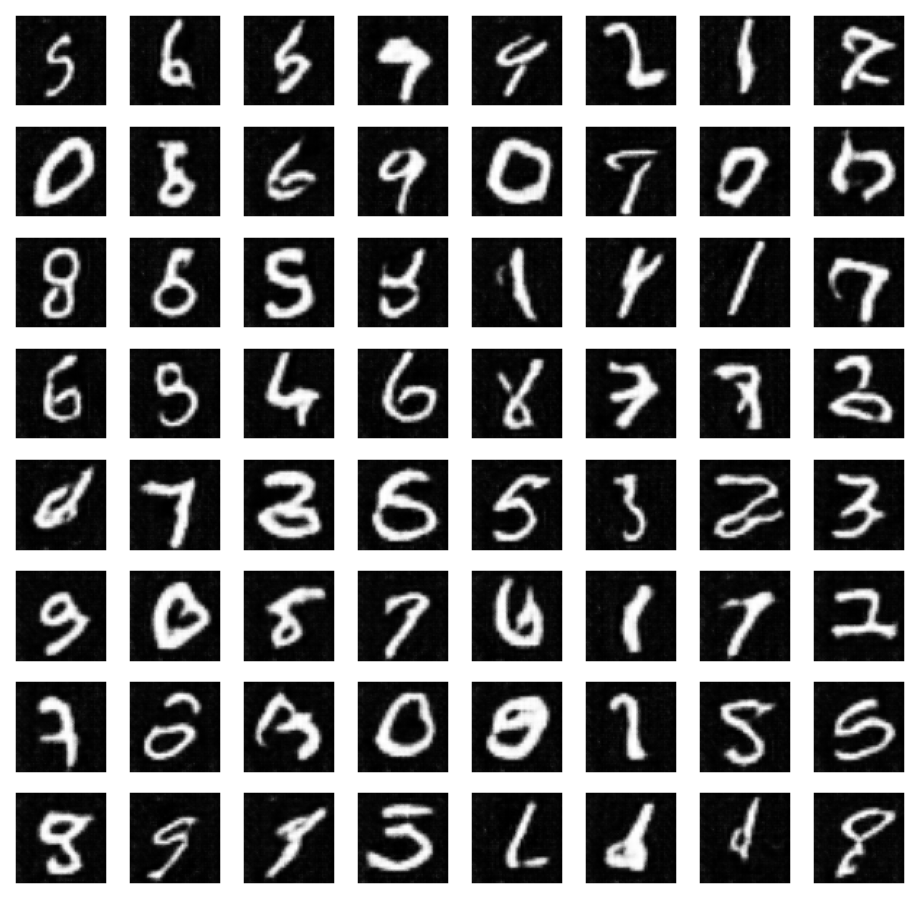

In [ ]:
noise = torch.randn(64, z, 1, 1, device=device)
images = loaded_generator(noise)
plot_images(images.cpu().data)

## Loading and using CelebA checkpoints

In [ ]:
celeba_checkpoints = drive.CreateFile({'id':"1vsTFX7kOxmYGMw51AislwAKaaTuRBXct"})
celeba_checkpoints.GetContentFile('dcgan-checkpoints-CelebA.zip') # For the CelebA dataset

In [ ]:
!unzip dcgan-checkpoints-CelebA.zip

Archive:  dcgan-checkpoints-CelebA.zip
   creating: output/
  inflating: output/discriminator_epoch_2.pth  
  inflating: output/generator_epoch_0.pth  
  inflating: output/discriminator_epoch_1.pth  
  inflating: output/generator_epoch_2.pth  
  inflating: output/discriminator_epoch_3.pth  
  inflating: output/generator_epoch_1.pth  
  inflating: output/real_samples.png  
  inflating: output/generator_epoch_4.pth  
  inflating: output/discriminator_epoch_0.pth  
  inflating: output/fake_samples_epoch_%03d.png  
  inflating: output/generator_epoch_3.pth  
  inflating: output/discriminator_epoch_4.pth  


In [ ]:
n_channels = 3

In [ ]:
loaded_generator = Generator(n_channels).to(device)
loaded_generator.load_state_dict(torch.load("output/generator_epoch_4.pth"))
loaded_generator.eval()

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [ ]:
def plot_images(images):
    num_images = images.size(0)
    shape = (images.size(3), images.size(2), images.size(1))
    # determine the number of rows and columns required for the grid
    num_rows = num_cols = math.ceil(math.sqrt(num_images))

    fig = plt.figure(figsize=(12, 12))
    plt.axis('off')

    for image_idx in range(num_images):
        plt.subplot(num_rows, num_cols, image_idx + 1)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow((images[image_idx, :].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2 )
        #plt.imshow(np.reshape(np.clip(images[image_idx, :].numpy(), 0, 1), newshape=shape))

    plt.show()

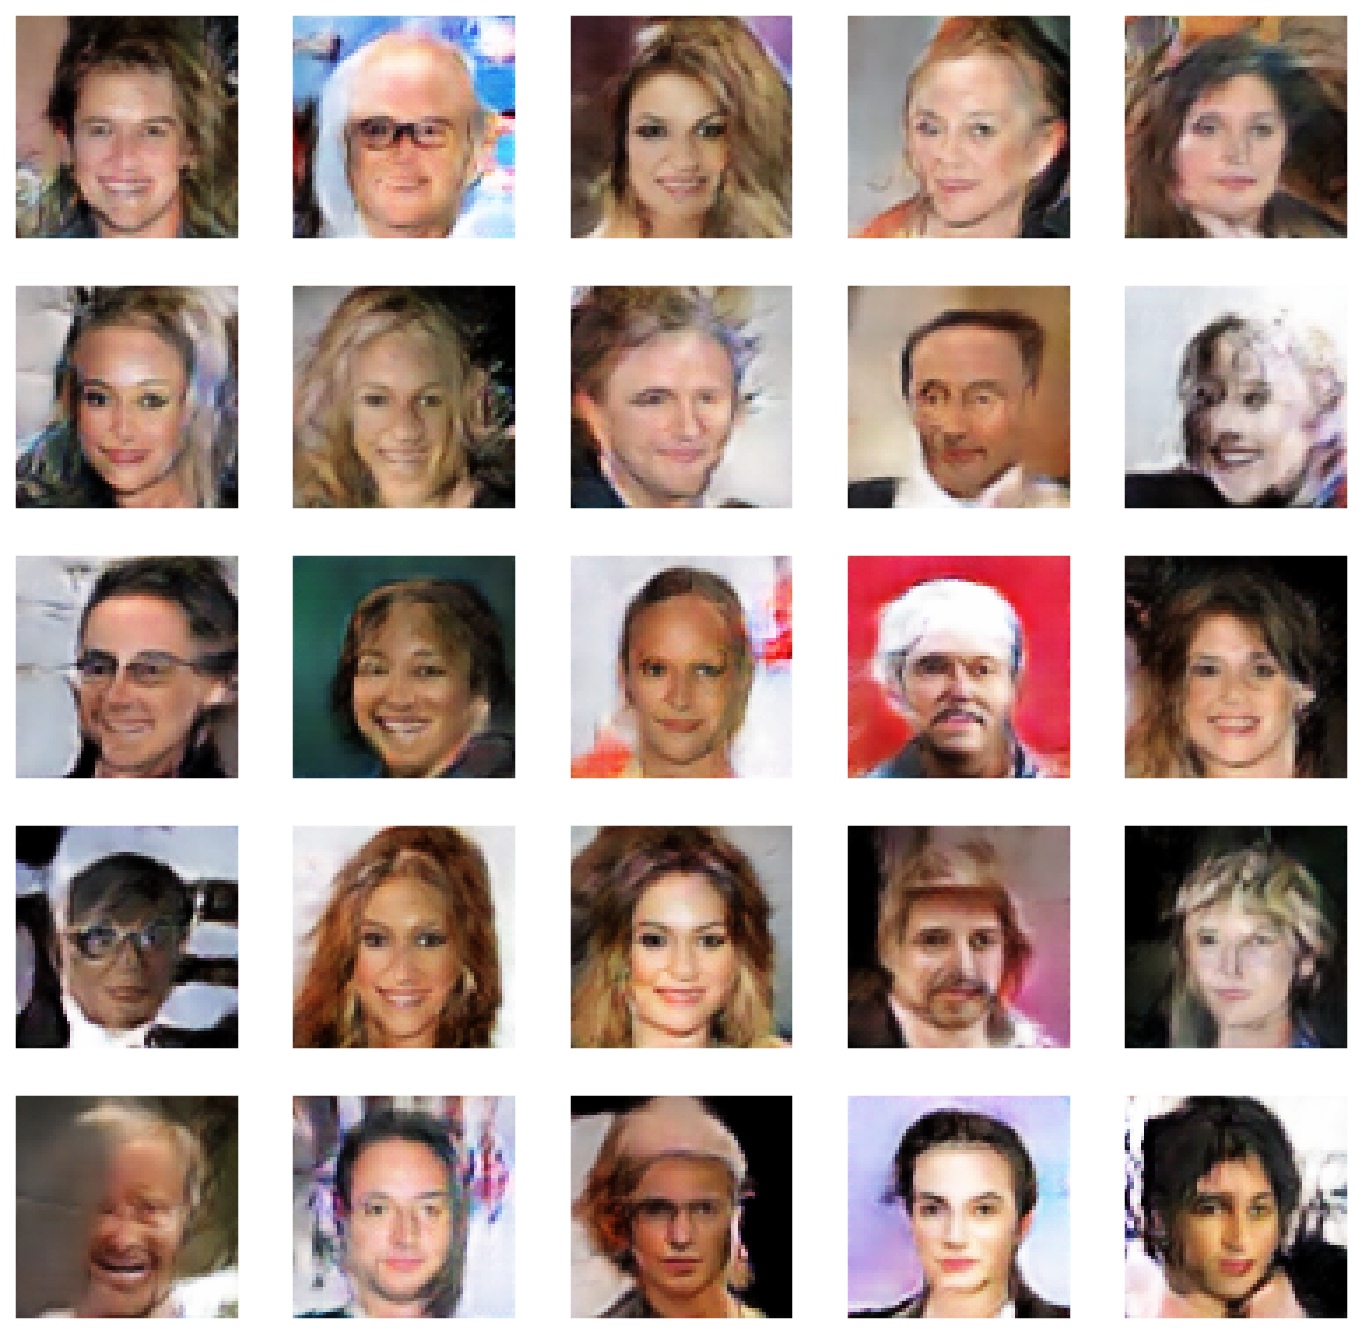

In [ ]:
noise = torch.randn(25, z, 1, 1, device=device)
images = loaded_generator(noise)
plot_images(images)